In [153]:
import pandas as pd
import networkx as nx
import os
import json
import powerlaw as pl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

In [154]:
#first, get the landpoint coordinates:
landPointDf = pd.read_csv("landpoints.csv")

cityLookup = {}
for l in landPointDf.itertuples():
    #add the city name for all 4 possible coordinates
    longitude = int(l.longitude)
    latitude = int(l.latitude)
    cityLookup[(longitude, latitude)] = l.description
    cityLookup[(-longitude, latitude)] = l.description
    cityLookup[(longitude, -latitude)] = l.description
    cityLookup[(-longitude, -latitude)] = l.description
    
#make a set with all the landing point coordinates
landPointCoords = set(cityLookup.keys())

In [155]:
#now extract a big set that contains all the coorinates that appear multiple times (important coordinates!)
# Directory with .geojson files
input_dir = "cablesGeojson"
output_file = "all_cables.csv"

def normCoord(long, lat):
    """Converts floating point coordinates to integers for easier comparisons!"""
    return (int(round(long * 1e6)), int(round(lat * 1e6)))

def coordBack(normedCoord):
    """Get the coord back from int to float"""
    return (float(normedCoord[0]) * 1e-6, float(normedCoord[1] * 1e-6))

# Loop through all files in the directory

cableCoords = []
for filename in os.listdir(input_dir):#iterate over all .geojson files
    if filename.endswith(".geojson"):
        filepath = os.path.join(input_dir, filename)
        #print(f"Processing {filepath} ...")

        # Load geojson file
        with open(filepath, "r", encoding="utf-8") as f:
            data = json.load(f)

        # Extract cable info
        for feature in data["features"]:
            coords = feature["geometry"].get("coordinates", [])
            if not coords:
                raise ValueError#this should never happen, cables should always have some coordinates!
            coords = [normCoord(c[0], c[1]) for c in coords]#get a list of tuples of coordinates of this cable segment
            cableCoords.extend(coords)#add the coordinates to the list
            
coordSet = set()
duplicateCoordSet = set()#set that will contain all the cable coordinates that appear multiple times
for c in cableCoords:
    if abs(c[0]) == 180000000:#cables at the 180th longitude have to be marked as important always, otherwise connections accross this border won't appear
        duplicateCoordSet.add(c)
    elif c not in coordSet:
        coordSet.add(c)
    else:
        duplicateCoordSet.add(c)#we found a duplicate

In [156]:
relevantCoords = duplicateCoordSet.union(landPointCoords)#these will be all the important coordinates!
#now go through all the cables again and for each one add edges between all pairs of relevant coordinates with weight equal to the cable's capacity

oG = nx.Graph()
cableCapacities = pd.read_csv("withCapacity.csv")

oneCount = 0#how often was there a cable that wasn't added because only 1 of its coordinates was important?
zeroCount = 0#how often was there a cable that had no relevant coordinate at all???

# Loop through all files in the directory
for filename in os.listdir(input_dir):
    if filename.endswith(".geojson"):
        filepath = os.path.join(input_dir, filename)

        # Load geojson file
        with open(filepath, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        # Extract cable info
        for feature in data["features"]:
            name = feature["properties"].get("Name", "Unknown")
            coords = feature["geometry"].get("coordinates", [])
            if not coords:
                raise ValueError#shouldn't happen
            coords = [normCoord(c[0], c[1]) for c in coords]#get a list of tuples of coordinates of this cable segment
            relevantCs = [c for c in coords if c in relevantCoords]#get only the relevant coordinates from this cable segment
            for i in range(len(relevantCs)):
                if abs(relevantCs[i][0])==180000000:
                    relevantCs[i] = (abs(relevantCs[i][0]), relevantCs[i][1])
            if len(relevantCs) == 0:#add the edge anyways, both endpoints will be marked as "undersea"
                oG.add_edge(coords[0], coords[-1], name=name, capacity=cableCapacities[cableCapacities["name"] == name]["capacity"].values[0])#add the edge with the cable capacity & name
                zeroCount+=1
            if len(relevantCs) == 1:
                oG.add_node(relevantCs[0], description="singleton")#WARNING: this name will actually be overwritten by <cityname> if this is a city!
                oneCount+=1
            for i in range(len(relevantCs)-1):#add edge between adjacent important points (adjacent on the cable)
                oG.add_edge(relevantCs[i], relevantCs[i+1], name=name, capacity=cableCapacities[cableCapacities["name"] == name]["capacity"].values[0])#add the edge with the cable capacity & name


print(oneCount)
print(zeroCount)                 
print(oG)

58
6
Graph with 1283 nodes and 1531 edges


In [157]:
#now rename the stuff

# Build a mapping old_node -> new_node_id
mapping = {}
new_attrs = {}
unique_countries = set()
for idx, node in enumerate(oG.nodes()):
    lon, lat = node
    city_name = None
    #now try to match to a city - country
    if (lon, lat) in cityLookup:
        city_country_name = cityLookup.get((lon, lat)).strip(')').split(' (')
        #print(city_country_name)
        city_name = city_country_name[0]
        country_name = city_country_name[-1]
        #print(city_name)
        #print(country_name)
    else:
        city_name = "undersea"
        country_name = "undersea"
    
    unique_countries.add(country_name)
    mapping[node] = idx  # old coordinate node -> new integer id
    realCoords = coordBack((lon, lat))
    new_attrs[idx] = {
        "lon": realCoords[0],#assign the proper coordinate!
        "lat": realCoords[1],
        "city": city_name,
        "country" : country_name
    }

# Relabel nodes
oG = nx.relabel_nodes(oG, mapping)

# Add the attributes
nx.set_node_attributes(oG, new_attrs)

In [158]:
#remove redundant nodes: (the ones on the seafloor that connect to the same cable twice)
for n, d in list(oG.nodes(data=True)):
    if d["city"] == "undersea":
        if oG.degree[n] == 2:
            edges = list(oG.edges(n, data=True))
            if edges[0][2]["name"] == edges[1][2]["name"]:
                neighbors = list(oG.neighbors(n))#there will be 2 neighbors
                oG.add_edge(neighbors[0], neighbors[1], name=edges[0][2]["name"], capacity=edges[0][2]["capacity"])#add an edge between the two neighbors with the same cable name & capacity
                oG.remove_node(n)
                
print(oG)

Graph with 1031 nodes and 1279 edges


In [159]:
G = oG.copy()
unique_countries.remove("undersea")
unique_countries.remove("")

In [160]:
for c in unique_countries:
    nodes = []
    for n, d in G.nodes(data= True):
        if d['country'] == c:
            nodes.append(n)
    
    #G.add_edge(nodes[0], nodes[-1])
    for i in range(len(nodes)-1):
        G.add_edge(nodes[i], nodes[i+1])


In [161]:
# FOR RANDOM GRAPH

# obtain degree frequencies
deg_freq_oG = {}
for n, d in oG.degree:
    deg_freq_oG.setdefault(d, 0)
    deg_freq_oG[d] += 1

# sort it bc why not
deg_freq_oG = dict(sorted(deg_freq_oG.items(), key= lambda x:x[0]))

# compute CCDF ~ inverse CDF: cumulative sum from last to first
ccdf_oG = list(np.cumsum(list(deg_freq_oG.values())[::-1]))[::-1]
ccdf_oG = np.array(ccdf_oG) / ccdf_oG[0]  # normalize it

In [162]:
# FOR RANDOM GRAPH

# obtain degree frequencies
deg_freq_G = {}
for n, d in G.degree:
    deg_freq_G.setdefault(d, 0)
    deg_freq_G[d] += 1

# sort it bc why not
deg_freq_G = dict(sorted(deg_freq_G.items(), key= lambda x:x[0]))

# compute CCDF ~ inverse CDF: cumulative sum from last to first
ccdf_G = list(np.cumsum(list(deg_freq_G.values())[::-1]))[::-1]
ccdf_G = np.array(ccdf_G) / ccdf_G[0]  # normalize it

0.8764187925372399


C:\Users\piras\AppData\Local\Temp\ipykernel_35344\1328707865.py:26: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(xmin, xmax)
C:\Users\piras\AppData\Local\Temp\ipykernel_35344\1328707865.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


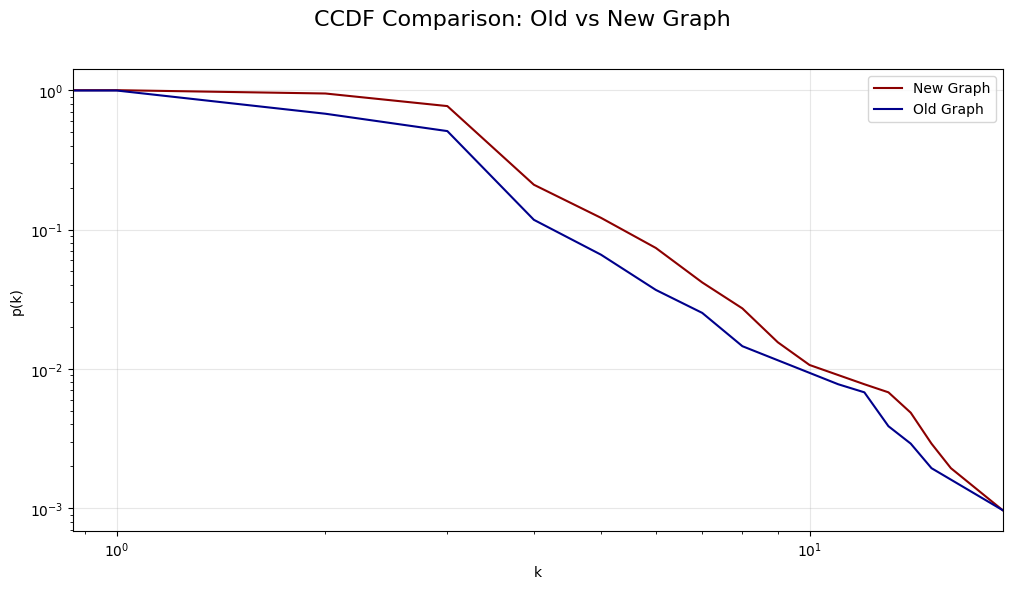

In [163]:
# plot results

fig = plt.figure(figsize=(12, 6))
fig.suptitle("CCDF Comparison: Old vs New Graph", fontsize=16)

# plot for real graph ccdf
ax1 = fig.add_subplot(1, 1, 1)
ax1.loglog(list(deg_freq_G.keys()), ccdf_G, color= 'darkred', label= "New Graph")

ax1.set_xlabel('k')
ax1.set_ylabel('p(k)')

# plot for random graph ccdf
ax1.loglog(list(deg_freq_oG.keys()), ccdf_oG, color= 'darkblue', label= 'Old Graph')

ax1.grid(alpha= 0.3)
ax1.legend()
ax1.set_xlabel('k')
ax1.set_ylabel('p(k)')

# make sure the axis have the same bounds

xmin = min(min(deg_freq_G.keys()), min(deg_freq_oG.keys()))
xmax = max(max(deg_freq_G.keys()), max(deg_freq_oG.keys()))

ax1.set_xlim(xmin, xmax)


fig.show()
# plt.savefig('CCDF_comparison.pdf')


# CONSIDERATIONS
# Random graph: much more 'condensed' degree distribution and less outliers,
#               so no nodes with very low or very high degree.
# Real graph:   expected ccdf, having many low degree nodes and a few nodes
#               with a remarkably high degree
corr, _ = pearsonr([n[1] for n in oG.degree], [n[1] for n in G.degree])
print(corr)


In [164]:
#visualize the graph with folium
import folium
import os

def plot_graph_folium(G, output_file="new_graph_map.html", cablesDir = None):
    # Extract coordinates from node attributes
    coords = [(d["lon"], d["lat"]) for _, d in G.nodes(data=True)]
    lons, lats = zip(*coords)
    
    # Center map on average position
    center_lat = sum(lats) / len(lats)
    center_lon = sum(lons) / len(lons)
    m = folium.Map(location=[center_lat, center_lon], zoom_start=3, tiles="CartoDB positron")

    # Add nodes
    for n, d in G.nodes(data=True):
        lon, lat = d["lon"], d["lat"]
        city, country = d['city'], d['country']
        location = f"lon: {lon} lat: {lat}"
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            popup=f"Node {n}<br>{city}<br>{country}<br>{location}",
            color="blue",
            fill=True,
            fill_color="blue",
            fill_opacity=0.7
        ).add_to(m)

    # Add edges
    for u, v in G.edges():
        lon1, lat1 = G.nodes[u]["lon"], G.nodes[u]["lat"]
        lon2, lat2 = G.nodes[v]["lon"], G.nodes[v]["lat"]
        folium.PolyLine(
            locations=[(lat1, lon1), (lat2, lon2)],
            color="red",
            weight=2,
            opacity=0.6
        ).add_to(m)
    
    #overlay the "real network"
    if cablesDir is not None:
        # Loop through all files in the directory
        for filename in os.listdir(cablesDir):
            if filename.endswith(".geojson"):
                filepath = os.path.join(cablesDir, filename)
                folium.GeoJson(filepath).add_to(m)

    # Save map as HTML
    m.save(output_file)
    print(f"Map saved to {output_file}")
    
plot_graph_folium(G, output_file="new_graph_map_overlayed_fixed.html", cablesDir="cablesGeojson/")
plot_graph_folium(G, output_file="new_graph_map_fixed.html")

Map saved to new_graph_map_overlayed_fixed.html
Map saved to new_graph_map_fixed.html
